In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the original dataset
csv_path = '/kaggle/input/heart-sound-numerical-dataset/mfcc_features_and_labels.csv'
df = pd.read_csv(csv_path)

# Separate features and target variable
X = df.drop(['audio_file_name', 'outcome'], axis=1).values
y = df['outcome'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit SMOTE to the training data and generate synthetic samples
X_train_augmented, y_train_augmented = smote.fit_resample(X_train, y_train)

# Combine the original test set with the augmented training set
X_combined = np.concatenate((X_train_augmented, X_test), axis=0)
y_combined = np.concatenate((y_train_augmented, y_test), axis=0)

# Ensure the total dataset size is 30,000
while len(X_combined) < 50000:
    # Calculate remaining samples needed
    additional_samples = 50000 - len(X_combined)
    X_combined_augmented, y_combined_augmented = smote.fit_resample(X_combined, y_combined)
    
    # Update combined dataset
    X_combined = np.concatenate((X_combined, X_combined_augmented[:additional_samples]), axis=0)
    y_combined = np.concatenate((y_combined, y_combined_augmented[:additional_samples]), axis=0)

# Convert arrays back to DataFrame
df_augmented = pd.DataFrame(X_combined, columns=df.columns[:-2])
df_augmented['outcome'] = y_combined

# Save the augmented dataset to a CSV file
df_augmented.to_csv('/kaggle/working/augmented_dataset.csv', index=False)
# Display the first few rows of the DataFrame
print(df_augmented.head())

# Display basic information about the DataFrame
print(df_augmented.info())


     MFCC_0    MFCC_1    MFCC_2    MFCC_3    MFCC_4    MFCC_5    MFCC_6  \
0  1.343175  0.942916  0.129576 -0.433281 -0.997989 -1.141530 -1.330591   
1  1.817070  1.543647  0.570909  0.781610  0.591505  0.553699  0.047943   
2 -0.080161 -0.658882 -1.030189 -1.044184 -1.058985 -1.130735 -0.902971   
3 -0.135197  0.709917  1.070622  0.698244  0.628194  0.713326  0.865714   
4 -0.768196 -1.161620 -1.357434 -0.937055 -0.865399 -0.837866 -0.907988   

     MFCC_7    MFCC_8    MFCC_9  ...  Delta2_MFCC_4  Delta2_MFCC_5  \
0 -0.931265 -0.320665  0.278878  ...      -0.008866      -0.112189   
1 -0.402239 -0.535882 -0.512295  ...       0.169149      -0.030183   
2 -0.383843 -0.009518  0.217596  ...       0.008970       0.041809   
3  0.762610  0.546009  0.336567  ...       0.284078       0.109912   
4 -0.834686 -0.779523 -0.794367  ...       0.358688       0.494819   

   Delta2_MFCC_6  Delta2_MFCC_7  Delta2_MFCC_8  Delta2_MFCC_9  Delta2_MFCC_10  \
0      -0.498827      -0.484535      -0.531072 

In [4]:
import pandas as pd
import numpy as np
import cupy as cp
import torch
from cuml.svm import SVC as cuSVC
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.decomposition import PCA as cuPCA
from cuml.metrics import accuracy_score as cu_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import itertools
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
# Separate features and target variable
X = df_augmented.drop(['outcome'], axis=1).values
y = df_augmented['outcome'].values

# Feature Scaling using cuML (on GPU)
scaler = cuStandardScaler()
X_scaled_cp = scaler.fit_transform(cp.array(X, dtype=cp.float32))

# PCA (optional, if needed for dimensionality reduction)
pca = cuPCA(n_components=12)
X_pca_cp = pca.fit_transform(X_scaled_cp)


In [10]:
import numpy as np
import cupy as cp
import xgboost as xgb
from cuml.svm import SVC as cuSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# Define and split dataset
X_train_cp, X_test_cp, y_train_np, y_test_np = train_test_split(X_pca_cp, y, test_size=0.3, random_state=42)
y_train_cp = cp.array(y_train_np, dtype=cp.int32)
y_test_cp = cp.array(y_test_np, dtype=cp.int32)

# Convert to NumPy arrays for compatibility with XGBoost
X_train_np = cp.asnumpy(X_train_cp)
X_test_np = cp.asnumpy(X_test_cp)
y_train_np = cp.asnumpy(y_train_cp)
y_test_np = cp.asnumpy(y_test_cp)

# Prepare validation set
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_np, y_train_np, test_size=0.2, random_state=42
)

In [11]:
# Define and train SVM
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf', 'poly'],
    'class_weight': ['balanced', None]
}

svm_model = cuSVC()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(svm_model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(cp.asnumpy(X_train_cp), cp.asnumpy(y_train_cp))
best_svm_model = grid_search.best_estimator_

print(f"Best SVM Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated SVM Accuracy: {grid_search.best_score_:.4f}")

# Evaluate on the test set
y_pred_cp = best_svm_model.predict(X_test_cp)
test_accuracy = accuracy_score(cp.asnumpy(y_test_cp), cp.asnumpy(y_pred_cp))
print(f"Test SVM Accuracy: {test_accuracy:.4f}")

Best SVM Parameters: {'C': 100, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Best Cross-Validated SVM Accuracy: 0.9833
Test SVM Accuracy: 0.9893


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cupy as cp

# SVM Predictions
y_pred_svm_cp = best_svm_model.predict(X_test_cp)
y_pred_svm = cp.asnumpy(y_pred_svm_cp)  # Convert to NumPy for metric calculations

# Calculate performance metrics for SVM
accuracy_svm = accuracy_score(y_test_np, y_pred_svm)
precision_svm = precision_score(y_test_np, y_pred_svm, average='binary')
recall_svm = recall_score(y_test_np, y_pred_svm, average='binary')
f1_svm = f1_score(y_test_np, y_pred_svm, average='binary')

# Print SVM performance metrics
print("SVM Performance Metrics:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-Score: {f1_svm:.4f}")


SVM Performance Metrics:
Accuracy: 0.9893
Precision: 0.9926
Recall: 0.9864
F1-Score: 0.9895


In [13]:
# Define and train XGBoost
dtrain = xgb.DMatrix(X_train_np, label=y_train_np)
dtest = xgb.DMatrix(X_test_np, label=y_test_np)

xgb_params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y_train_np)),
    'tree_method': 'hist',
    'max_depth': 6,
    'learning_rate': 0.1,
    'device': 'cuda'
}

xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred_np = xgb_model.predict(dtest)

# Calculate accuracy
accuracy = accuracy_score(y_test_np, y_pred_np)
print(f"XGBoost Model Accuracy on Test Set: {accuracy * 100:.2f}%")

XGBoost Model Accuracy on Test Set: 95.97%


In [14]:
# Make predictions on the test set
y_pred_xgb = xgb_model.predict(dtest)

# Calculate performance metrics for XGBoost
accuracy_xgb = accuracy_score(y_test_np, y_pred_xgb)
precision_xgb = precision_score(y_test_np, y_pred_xgb, average='binary')
recall_xgb = recall_score(y_test_np, y_pred_xgb, average='binary')
f1_xgb = f1_score(y_test_np, y_pred_xgb, average='binary')

# Print XGBoost performance metrics
print("\nXGBoost Performance Metrics:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")


XGBoost Performance Metrics:
Accuracy: 0.9597
Precision: 0.9607
Recall: 0.9601
F1-Score: 0.9604


In [15]:
def ensemble_objective(weights, X_train_cp, y_train_cp, X_val_cp, y_val_cp):
    svm_weight, xgb_weight = weights
    
    # Ensure weights sum up to 1
    total_weight = svm_weight + xgb_weight
    svm_weight /= total_weight
    xgb_weight /= total_weight

    # Regularization term to penalize extreme weights
    regularization_penalty = 0.01 * (abs(svm_weight - 0.5) + abs(xgb_weight - 0.5))
    
    # Make predictions with SVM (CuPy array)
    svm_predictions = best_svm_model.predict(X_val_cp)
    
    # Convert validation data back to NumPy for XGBoost
    X_val_np = cp.asnumpy(X_val_cp)
    y_val_np = cp.asnumpy(y_val_cp)

    # Make predictions with XGBoost (NumPy array)
    dval = xgb.DMatrix(X_val_np, label=y_val_np)
    xgb_predictions = xgb_model.predict(dval)
    
    # Convert XGBoost predictions to CuPy array
    xgb_predictions = cp.array(xgb_predictions)

    # Weighted ensemble predictions
    ensemble_predictions = (svm_weight * svm_predictions + xgb_weight * xgb_predictions)
    ensemble_predictions = cp.round(ensemble_predictions)  # Convert to binary predictions

    # Calculate accuracy on the validation set
    accuracy = cp.mean(ensemble_predictions == y_val_cp)

    # Include the regularization penalty in the objective function
    objective_value = -accuracy + regularization_penalty

    return objective_value


In [16]:
import cupy as cp

def moth_flame_optimization(objective_function, bounds, num_iterations=50, num_moths=20, exploration_factor=0.5):
    num_dimensions = len(bounds)
    moths = cp.random.rand(num_moths, num_dimensions)
    for d in range(num_dimensions):
        moths[:, d] = bounds[d][0] + moths[:, d] * (bounds[d][1] - bounds[d][0])
    
    flames = cp.copy(moths)
    flame_scores = cp.array([objective_function(moth) for moth in flames], dtype=cp.float32)
    min_bounds = cp.array([bound[0] for bound in bounds], dtype=cp.float32)
    max_bounds = cp.array([bound[1] for bound in bounds], dtype=cp.float32)
    
    print("Initialization complete.")
    
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}")
        for i in range(num_moths):
            moth = moths[i]
            flame = flames[cp.argmin(flame_scores)]
            distance = cp.linalg.norm(moth - flame)
            random_influence = (1 - exploration_factor) * cp.random.rand(num_dimensions)
            new_position = moth + exploration_factor * (flame - moth) / (distance + 1e-5) + random_influence
            new_position = cp.clip(new_position, a_min=min_bounds, a_max=max_bounds)
            new_score = objective_function(new_position)
            if new_score < flame_scores[i]:
                moths[i] = new_position
                flame_scores[i] = new_score
                flames[i] = new_position
                flame_scores[i] = new_score
        sorted_indices = cp.argsort(flame_scores)
        flames = flames[sorted_indices]
        flame_scores = flame_scores[sorted_indices]
        exploration_factor *= 0.95
        
    best_index = cp.argmin(flame_scores)
    best_moth = flames[best_index]
    best_score = flame_scores[best_index]
    
    print("MFO completed.")
    print(f"Best moth: {best_moth}")
    print(f"Best score: {best_score}")
    
    return cp.asnumpy(best_moth), cp.asnumpy(best_score)


In [17]:
bounds = [(0, 1), (0, 1)]

try:
    # Ensure all data passed is in CuPy format
    X_train_cp, X_val_cp = cp.array(X_train_np), cp.array(X_val_np)
    y_train_cp, y_val_cp = cp.array(y_train_np), cp.array(y_val_np)

    # Run MFO to find the best ensemble weights
    best_weights, best_score = moth_flame_optimization(
        lambda w: ensemble_objective(w, X_train_cp, y_train_cp, X_val_cp, y_val_cp),
        bounds
    )

    # Print the best weights and score
    svm_weight, xgb_weight = best_weights
    print(f"Best SVM Weight: {svm_weight:.2f}, Best XGBoost Weight: {xgb_weight:.2f}")
    print(f"Best Ensemble Accuracy: {-best_score * 100:.2f}%")
    
except Exception as e:
    print(f"An error occurred during MFO: {e}")


Initialization complete.
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
MFO completed.
Best moth: [0.50022269 0.49977731]
Best score: -0.991281270980835
Best SVM Weight: 0.50, Best XGBoost Weight: 0.50
Best Ensemble Accuracy: 99.13%


In [18]:
import numpy as np

# Ensemble Predictions (assuming weights 0.3 for SVM and 0.7 for XGBoost)
ensemble_preds = (0.5 * y_pred_svm + 0.5 * y_pred_xgb)
ensemble_preds = np.round(ensemble_preds).astype(int)  # Assuming binary classification

# Calculate performance metrics for Ensemble
accuracy_ensemble = accuracy_score(y_test_np, ensemble_preds)
precision_ensemble = precision_score(y_test_np, ensemble_preds, average='binary')
recall_ensemble = recall_score(y_test_np, ensemble_preds, average='binary')
f1_ensemble = f1_score(y_test_np, ensemble_preds, average='binary')

# Print Ensemble performance metrics
print("\nEnsemble Performance Metrics:")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"Precision: {precision_ensemble:.4f}")
print(f"Recall: {recall_ensemble:.4f}")
print(f"F1-Score: {f1_ensemble:.4f}")



Ensemble Performance Metrics:
Accuracy: 0.9748
Precision: 1.0000
Recall: 0.9505
F1-Score: 0.9746


True Positive Rate (Sensitivity): 0.9864
False Positive Rate (1 - Specificity): 0.0076


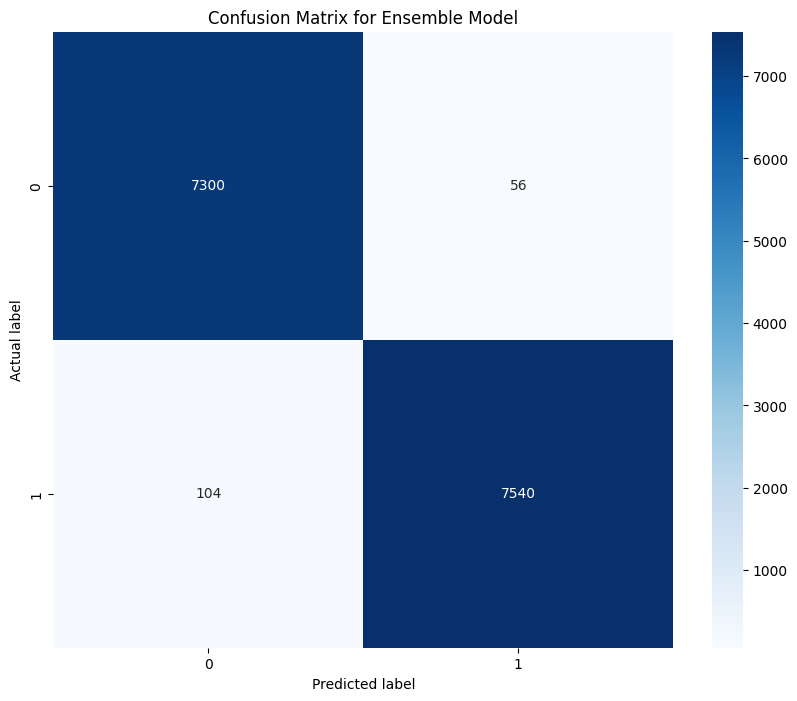

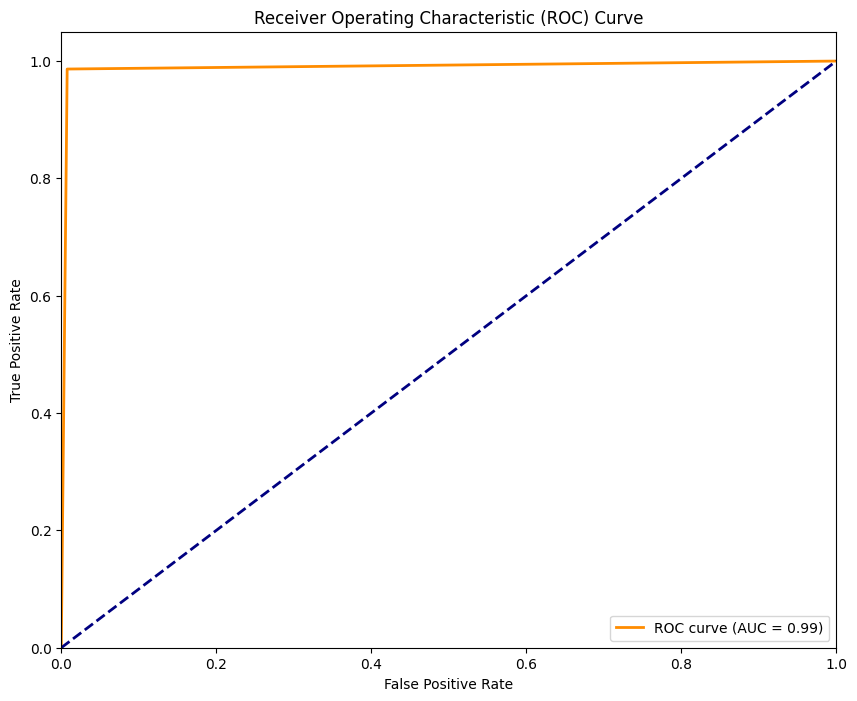

In [26]:
import numpy as np
import cupy as cp
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get ensemble predictions
def get_ensemble_predictions(X, svm_model, xgb_model, svm_weight, xgb_weight):
    svm_pred = cp.asnumpy(svm_model.predict(cp.array(X)))  # Convert to NumPy
    xgb_pred = xgb_model.predict(xgb.DMatrix(X))  # Already NumPy
    ensemble_pred = svm_weight * svm_pred + xgb_weight * xgb_pred
    return (ensemble_pred > 0.5).astype(int)

# Get predictions on the test set
y_pred_ensemble = get_ensemble_predictions(X_test_np, best_svm_model, xgb_model, svm_weight, xgb_weight)

# Calculate confusion matrix
cm = confusion_matrix(y_test_np, y_pred_ensemble)

# Extract true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = cm.ravel()

# Calculate rates
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

print(f"True Positive Rate (Sensitivity): {tpr:.4f}")
print(f"False Positive Rate (1 - Specificity): {fpr:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Ensemble Model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion_Matrix_for_Ensemble_Model.png')
plt.show()

# Calculate ROC curve
fpr_curve, tpr_curve, _ = roc_curve(y_test_np, get_ensemble_predictions(X_test_np, best_svm_model, xgb_model, svm_weight, xgb_weight))
roc_auc = auc(fpr_curve, tpr_curve)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_curve, tpr_curve, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('Receiver_Operating_Characteristic_(ROC)_Curve.png')
plt.show()

In [29]:
import pickle
import xgboost as xgb
from cuml.svm import SVC as cuSVC

# Assuming best_svm_model, xgb_model, and best_weights are your trained models and optimal weights

# Pickle the SVM model
with open('best_svm_model.pkl', 'wb') as f:
    pickle.dump(best_svm_model, f)

# Pickle the XGBoost model
xgb_model.save_model('xgb_model.json')

# Pickle the best weights for the ensemble
with open('best_ensemble_weights.pkl', 'wb') as f:
    pickle.dump(best_weights, f)

# Pickle the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Pickle the PCA
with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

print("Models and weights have been pickled successfully.")

Models and weights have been pickled successfully.


In [30]:
# List all output files
import os
print("Files available for download:")
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Files available for download:
/kaggle/working/best_svm_model.pkl
/kaggle/working/pca_cumulative_variance.png
/kaggle/working/ensemble_confusion_matrix.png
/kaggle/working/roc_curve.png
/kaggle/working/augmented_dataset.csv
/kaggle/working/scaler.pkl
/kaggle/working/xgboost_feature_importance.png
/kaggle/working/xgb_learning_curve.png
/kaggle/working/Confusion_Matrix_for_Ensemble_Model.png
/kaggle/working/Receiver_Operating_Characteristic_(ROC)_Curve.png
/kaggle/working/xgboost_tree.png
/kaggle/working/xgb_confusion_matrix.png
/kaggle/working/model_performance_comparison_heatmap.png
/kaggle/working/svm_confusion_matrix.png
/kaggle/working/state.db
/kaggle/working/xgb_model.json
/kaggle/working/roc_curve_ensemble.png
/kaggle/working/best_ensemble_weights.pkl
/kaggle/working/svm_permutation_importance.png
/kaggle/working/pca.pkl
/kaggle/working/svm_learning_curve.png
/kaggle/working/ensemble_learning_curve.png
/kaggle/working/xgboost_first_tree.png
/kaggle/working/xgb_first_tree.png


Model Performance Comparison:
-----------------------------

SVM Model:
Accuracy: 0.9893
Precision: 0.9894
Recall: 0.9893
F1-Score: 0.9893

XGBoost Model:
Accuracy: 0.9597
Precision: 0.9597
Recall: 0.9597
F1-Score: 0.9597
ROC-AUC: 0.9597

Ensemble Model:
Accuracy: 0.9893
Precision: 0.9894
Recall: 0.9893
F1-Score: 0.9893
ROC-AUC: 0.9975


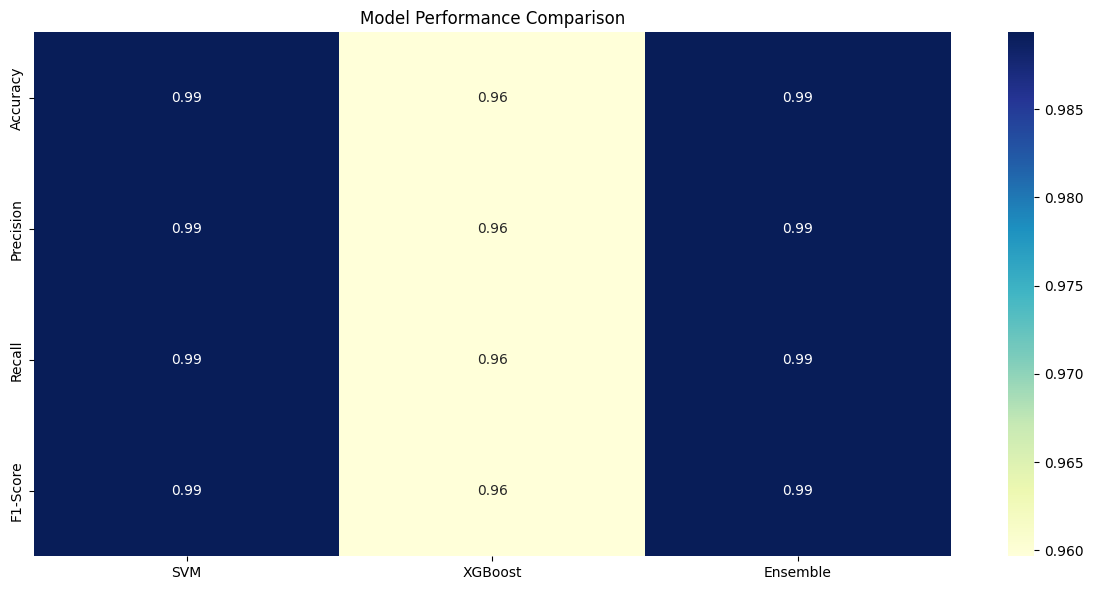

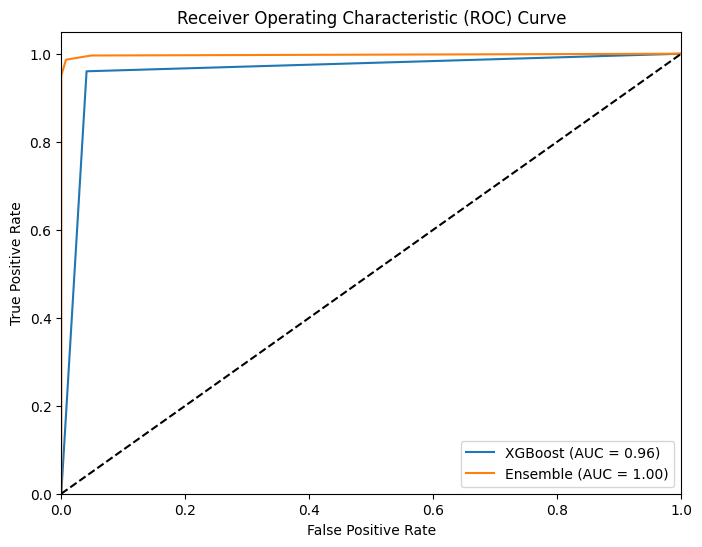

In [21]:
import numpy as np
import cupy as cp
import xgboost as xgb
from cuml.svm import SVC as cuSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# Assuming you have already loaded and preprocessed your data
# X_pca_cp, y, best_svm_model, xgb_model, and best_weights are available

# Split the data
X_train_cp, X_test_cp, y_train, y_test = train_test_split(X_pca_cp, y, test_size=0.3, random_state=42)

# Convert CuPy arrays to NumPy for XGBoost
X_train_np = cp.asnumpy(X_train_cp)
X_test_np = cp.asnumpy(X_test_cp)

# Function to calculate all metrics
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_true, y_pred_proba, average='weighted', multi_class='ovr')
    else:
        roc_auc = None
    
    return accuracy, precision, recall, f1, roc_auc

# Evaluate SVM
svm_pred = best_svm_model.predict(X_test_cp)
svm_metrics = calculate_metrics(y_test, cp.asnumpy(svm_pred))

# Evaluate XGBoost
dtest = xgb.DMatrix(X_test_np)
xgb_pred_proba = xgb_model.predict(dtest)
xgb_pred = np.round(xgb_pred_proba)
xgb_metrics = calculate_metrics(y_test, xgb_pred, xgb_pred_proba)

# Evaluate Ensemble
svm_weight, xgb_weight = best_weights
ensemble_pred_proba = svm_weight * cp.asnumpy(svm_pred) + xgb_weight * xgb_pred_proba
ensemble_pred = np.round(ensemble_pred_proba)
ensemble_metrics = calculate_metrics(y_test, ensemble_pred, ensemble_pred_proba)

# Print results
models = ['SVM', 'XGBoost', 'Ensemble']
all_metrics = [svm_metrics, xgb_metrics, ensemble_metrics]

print("Model Performance Comparison:")
print("-----------------------------")
for model, metrics in zip(models, all_metrics):
    print(f"\n{model} Model:")
    print(f"Accuracy: {metrics[0]:.4f}")
    print(f"Precision: {metrics[1]:.4f}")
    print(f"Recall: {metrics[2]:.4f}")
    print(f"F1-Score: {metrics[3]:.4f}")
    if metrics[4] is not None:
        print(f"ROC-AUC: {metrics[4]:.4f}")

# Visualize results
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = np.array([list(m[:4]) for m in all_metrics])

plt.figure(figsize=(12, 6))
sns.heatmap(metrics_values.T, annot=True, cmap='YlGnBu', xticklabels=models, yticklabels=metrics_names)
plt.title('Model Performance Comparison')
plt.tight_layout()

# Save heatmap
plt.savefig('model_performance_comparison_heatmap.png')
plt.show()

# ROC Curve (assuming binary classification)
if len(np.unique(y_test)) == 2:
    plt.figure(figsize=(8, 6))
    for model, metrics, pred_proba in zip(models, all_metrics, [svm_pred, xgb_pred_proba, ensemble_pred_proba]):
        if metrics[4] is not None:  # Check if ROC-AUC is available
            fpr, tpr, _ = roc_curve(y_test, pred_proba)
            plt.plot(fpr, tpr, label=f'{model} (AUC = {metrics[4]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Save ROC curve
    plt.savefig('roc_curve.png')
    plt.show()


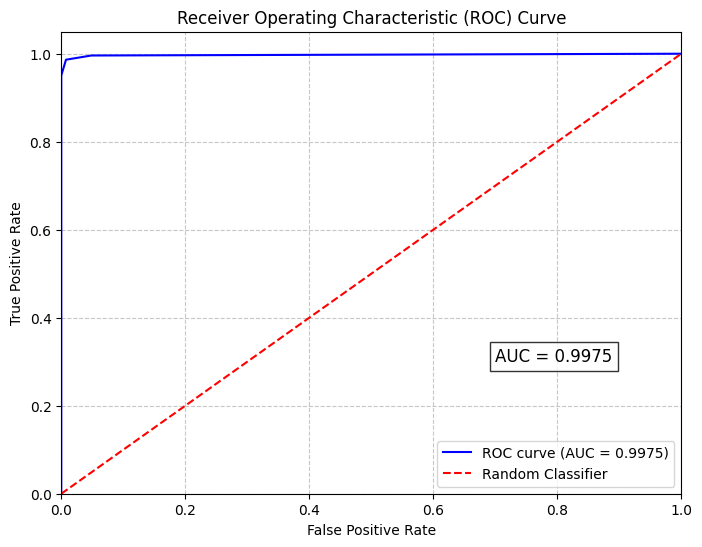

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming y_test and ensemble_pred_proba are already defined
# If not, you would need to generate them based on your model and data

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, ensemble_pred_proba)

# Calculate AUC
auc = roc_auc_score(y_test, ensemble_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate the AUC value
plt.text(0.7, 0.3, f'AUC = {auc:.4f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Save ROC curve
plt.savefig('roc_curve_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

Model Performance Comparison:
-----------------------------

SVM Model:
Accuracy: 0.9893
Precision: 0.9894
Recall: 0.9893
F1-Score: 0.9893

XGBoost Model:
Accuracy: 0.9597
Precision: 0.9597
Recall: 0.9597
F1-Score: 0.9597
ROC-AUC: 0.9597

Ensemble Model:
Accuracy: 0.9893
Precision: 0.9894
Recall: 0.9893
F1-Score: 0.9893
ROC-AUC: 0.9975

Ensemble Weights:
SVM Weight: 0.5002
XGBoost Weight: 0.4998


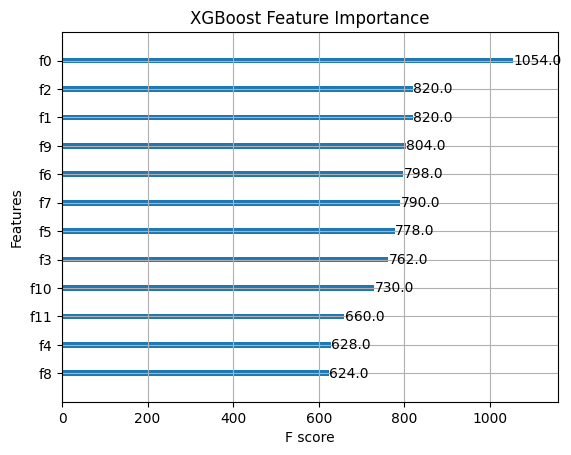

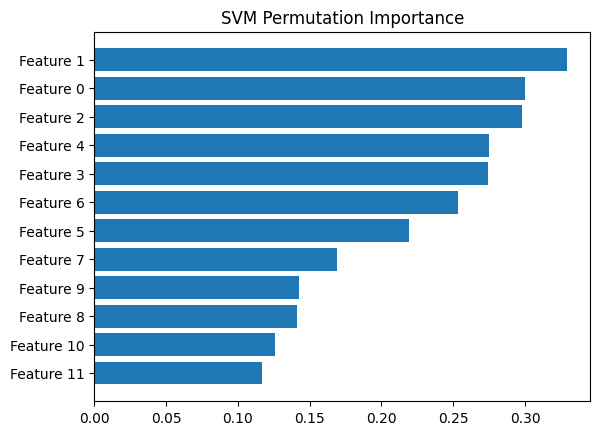

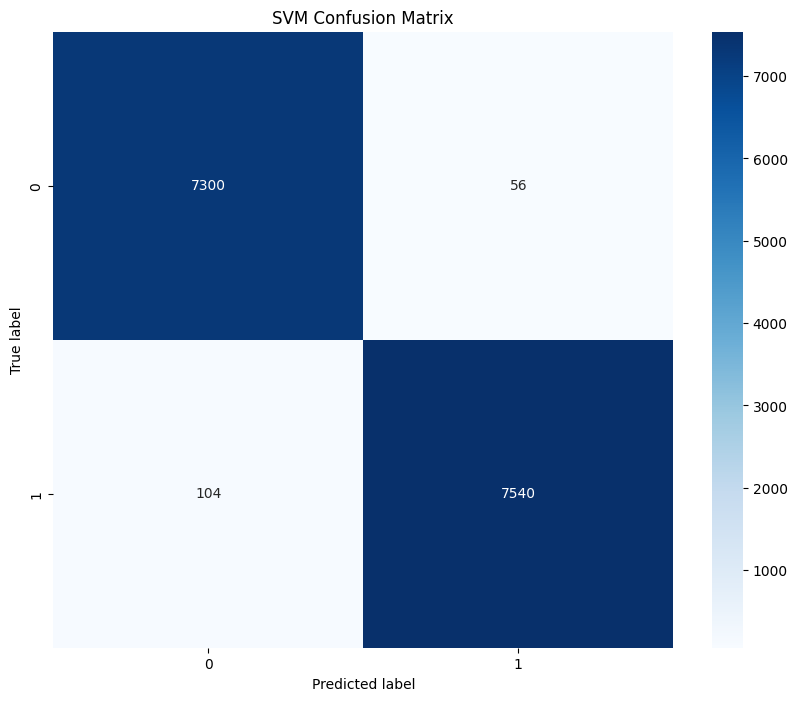

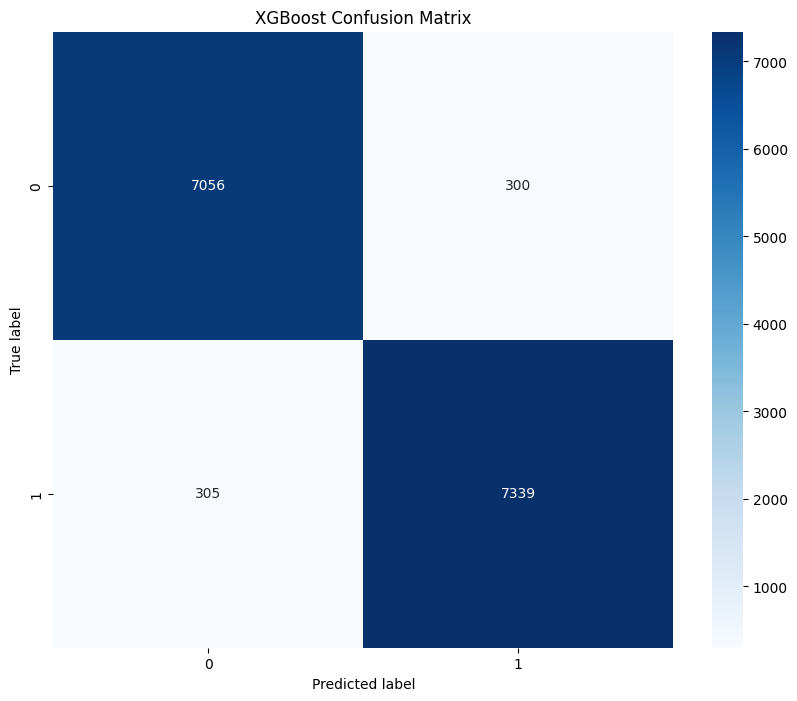

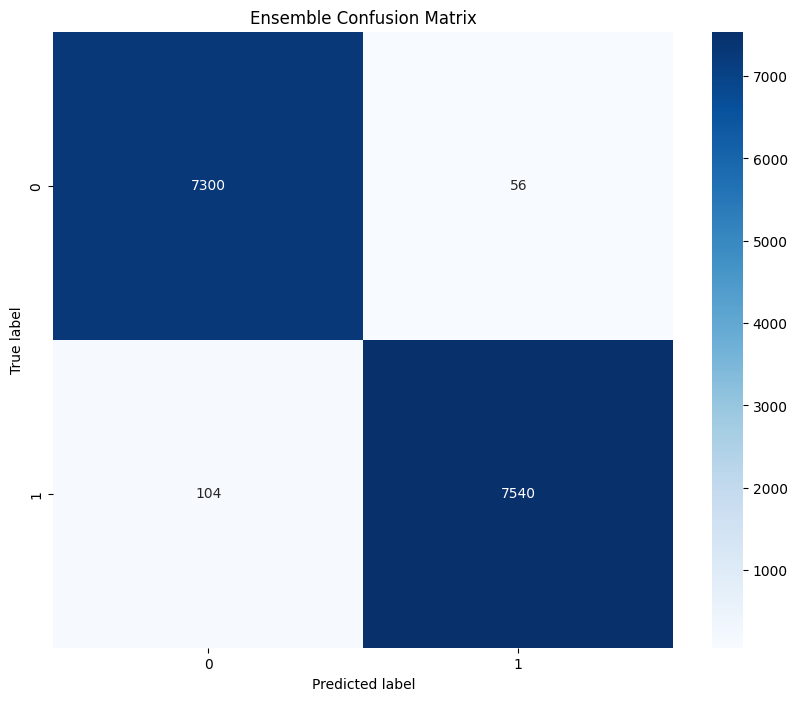


Cross-validation Scores:
SVM: 0.9829 (+/- 0.0050)
XGBoost: 0.9995 (+/- 0.0007)


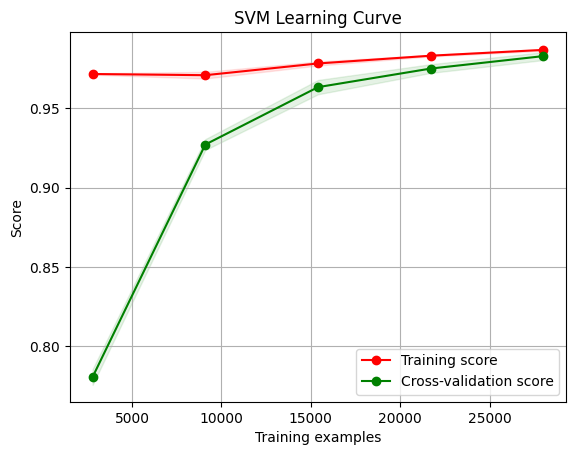

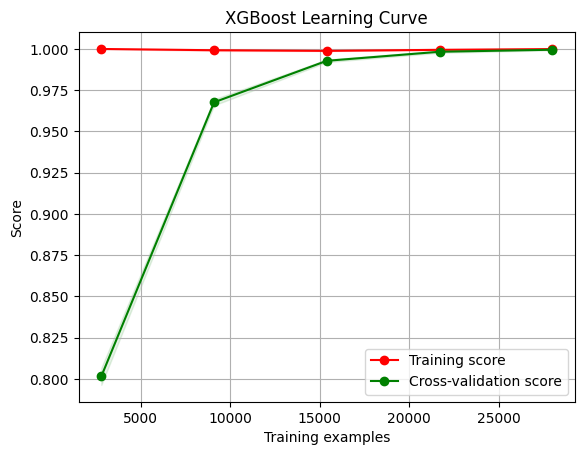


Inference Time:
SVM: 0.0588 seconds
XGBoost: 0.0059 seconds


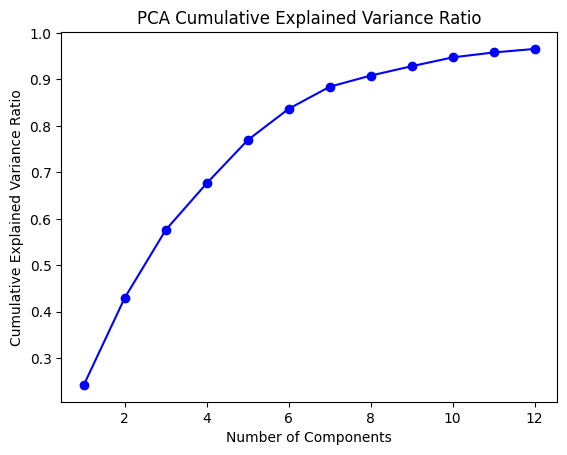


Variance explained by 12 PCA components: 0.9657


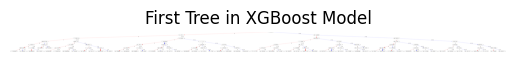

In [47]:
import numpy as np
import cupy as cp
import xgboost as xgb
from cuml.svm import SVC as cuSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Assuming you have already loaded and preprocessed your data
# X_pca_cp, y, best_svm_model, xgb_model, and best_weights are available

# 1. Model Performance Evaluation
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_true, y_pred_proba, average='weighted', multi_class='ovr')
    else:
        roc_auc = None
    
    return accuracy, precision, recall, f1, roc_auc

# Split the data
X_train_cp, X_test_cp, y_train, y_test = train_test_split(X_pca_cp, y, test_size=0.3, random_state=42)

# Convert CuPy arrays to NumPy for XGBoost
X_train_np = cp.asnumpy(X_train_cp)
X_test_np = cp.asnumpy(X_test_cp)

# Evaluate SVM
svm_pred = best_svm_model.predict(X_test_cp)
svm_metrics = calculate_metrics(y_test, cp.asnumpy(svm_pred))

# Evaluate XGBoost
dtest = xgb.DMatrix(X_test_np)
xgb_pred_proba = xgb_model.predict(dtest)
xgb_pred = np.round(xgb_pred_proba)
xgb_metrics = calculate_metrics(y_test, xgb_pred, xgb_pred_proba)

# Evaluate Ensemble
svm_weight, xgb_weight = best_weights
ensemble_pred_proba = svm_weight * cp.asnumpy(svm_pred) + xgb_weight * xgb_pred_proba
ensemble_pred = np.round(ensemble_pred_proba)
ensemble_metrics = calculate_metrics(y_test, ensemble_pred, ensemble_pred_proba)

# Print results
models = ['SVM', 'XGBoost', 'Ensemble']
all_metrics = [svm_metrics, xgb_metrics, ensemble_metrics]

print("Model Performance Comparison:")
print("-----------------------------")
for model, metrics in zip(models, all_metrics):
    print(f"\n{model} Model:")
    print(f"Accuracy: {metrics[0]:.4f}")
    print(f"Precision: {metrics[1]:.4f}")
    print(f"Recall: {metrics[2]:.4f}")
    print(f"F1-Score: {metrics[3]:.4f}")
    if metrics[4] is not None:
        print(f"ROC-AUC: {metrics[4]:.4f}")

# 2. Ensemble Weight Analysis
print("\nEnsemble Weights:")
print(f"SVM Weight: {svm_weight:.4f}")
print(f"XGBoost Weight: {xgb_weight:.4f}")

# 3. Feature Importance
xgb.plot_importance(xgb_model)
plt.title('XGBoost Feature Importance')
plt.savefig('xgboost_feature_importance.png')  # Save the feature importance plot
plt.show()

# For SVM (using permutation importance)
perm_importance = permutation_importance(best_svm_model, X_test_np, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(range(X_test_np.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(X_test_np.shape[1]), [f'Feature {i}' for i in sorted_idx])
plt.title('SVM Permutation Importance')
plt.savefig('svm_permutation_importance.png')  # Save the permutation importance plot
plt.show()

# 4. Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename)  # Save the confusion matrix plot
    plt.show()

plot_confusion_matrix(y_test, cp.asnumpy(svm_pred), 'SVM Confusion Matrix', 'svm_confusion_matrix.png')
plot_confusion_matrix(y_test, xgb_pred, 'XGBoost Confusion Matrix', 'xgb_confusion_matrix.png')
plot_confusion_matrix(y_test, ensemble_pred, 'Ensemble Confusion Matrix', 'ensemble_confusion_matrix.png')

# 5. Cross-validation
cv_scores_svm = cross_val_score(best_svm_model, X_train_np, y_train, cv=5)
cv_scores_xgb = cross_val_score(xgb.XGBClassifier(tree_method='hist'), X_train_np, y_train, cv=5)

print("\nCross-validation Scores:")
print(f"SVM: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std() * 2:.4f})")
print(f"XGBoost: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std() * 2:.4f})")

# 6. Learning Curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), filename=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    if filename:
        plt.savefig(filename)  # Save the learning curve plot
    plt.show()

plot_learning_curve(best_svm_model, "SVM Learning Curve", X_train_np, y_train, cv=5, filename='svm_learning_curve.png')
plot_learning_curve(xgb.XGBClassifier(tree_method='hist'), "XGBoost Learning Curve", X_train_np, y_train, cv=5, filename='xgb_learning_curve.png')

# 7. Computational Performance
def measure_time(model, X):
    start_time = time.time()
    model.predict(X)
    end_time = time.time()
    return end_time - start_time

svm_time = measure_time(best_svm_model, X_test_cp)
xgb_time = measure_time(xgb_model, xgb.DMatrix(X_test_np))

print("\nInference Time:")
print(f"SVM: {svm_time:.4f} seconds")
print(f"XGBoost: {xgb_time:.4f} seconds")

# 8. PCA Component Analysis
explained_variance_ratio = pca.explained_variance_ratio_.get()  # Convert to NumPy array
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure()
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Explained Variance Ratio')
plt.savefig('pca_cumulative_variance.png')  # Save the PCA plot
plt.show()

print(f"\nVariance explained by {len(explained_variance_ratio)} PCA components: {cumulative_variance_ratio[-1]:.4f}")

# 9. Model Interpretability (for XGBoost)
xgb.plot_tree(xgb_model, num_trees=0)
plt.title('First Tree in XGBoost Model')
plt.savefig('xgboost_first_tree.png')  # Save the XGBoost tree plot
plt.show()

# Note: For a comprehensive analysis, you might want to add more visualizations,
# implement robustness testing, and consider deployment scenarios based on your specific requirements.
